# Regressions

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, Lasso, LinearRegression
from scipy.stats import skew
from sklearn import decomposition
import math
from sklearn.preprocessing import normalize

plt.style.use('ggplot')

On this step we use the train set to fit severl linear models.

In [2]:
# Load the train set
df = pd.read_csv('./data/new_train.csv')
df.drop(['Unnamed: 0', 'Id'], axis=1, inplace=True)

# Load categorical variables
numerical = pickle.load(open('./tmp/numerical.list', 'rb'))

df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA
0,65.0,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,5.017280,...,0,0,0,1,0,0,0,0,0,1
1,80.0,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,5.652489,...,1,0,0,0,0,0,0,0,0,1
2,68.0,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,6.075346,...,0,0,0,1,0,0,0,0,0,1
3,60.0,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,6.293419,...,0,0,0,1,0,0,0,0,0,1
4,84.0,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,6.196444,...,0,0,0,1,0,0,0,0,0,1


## Models fitted to the whole features set

First, we fit linear regression models to the whole dataset.

## Model 1: Linear regression on the whole set

In [3]:
data = df.copy()

# Create sets
X = data.copy().drop('SalePrice', axis=1)
y = np.log(data.copy()['SalePrice'])

X.shape

(1460, 278)

In [4]:
# Load numeric
numerical = pickle.load(open('./tmp/numerical.list', 'rb'))
numerical

['TotalBsmtSF',
 'GarageYrBlt',
 'OverallQual',
 'GrLivArea',
 'EnclosedPorch',
 'WoodDeckSF',
 'MasVnrArea',
 'OpenPorchSF',
 'BsmtUnfSF',
 'GarageCars',
 'Corn',
 'YearRemodAdd',
 '1stFlrSF',
 'BsmtFinSF1',
 'FullBath',
 'BsmtHalfBath',
 'BedroomAbvGr',
 'GarageArea',
 'BsmtFullBath',
 'LotArea',
 'PoolArea',
 'MoSold',
 'DJREI',
 'YearBuilt',
 'KitchenAbvGr',
 'ScreenPorch',
 'Fannie',
 'YrSold',
 'OverallCond',
 'MiscVal',
 'LotFrontage',
 'LowQualFinSF',
 'Month',
 'HalfBath',
 'TotRmsAbvGrd',
 '3SsnPorch',
 '2ndFlrSF',
 'BsmtFinSF2',
 'Fireplaces',
 'UnemplRate',
 'LaborForce']

In [5]:

# Divide the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1022, 278)
X_test : (438, 278)
y_train : (1022,)
y_test : (438,)


We create helper functions to evaluate results

In [6]:
def rmse_cv(model, X, y):
    '''
    A helper function to calculate the cross validated RMSE
    '''
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring = "neg_mean_squared_error", cv = 10))
    return(rmse)

In [7]:
def rmsle(model, X, y):
    '''
    Calculates rmsle as set by Kaggle
    '''
    return (math.sqrt(np.mean((np.log(np.exp(model.predict(X))) - np.log(np.exp(y))) ** 2)))

### Model 1a: Ridge normalization

Lowest rmse:  0.12199057098276275
Optimal alpha:  [6.]


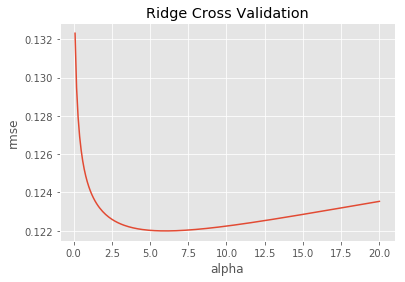

In [8]:
alphas = np.linspace(0.1,20,200)
cv_ridge = [rmse_cv(Ridge(alpha = alpha), X_train,y_train).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Ridge Cross Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")


print('Lowest rmse: ',cv_ridge.min())
print('Optimal alpha: ', cv_ridge[cv_ridge==cv_ridge.min()].index.values)

alpha = cv_ridge[cv_ridge==cv_ridge.min()].index.values

Fit model to the new train dataset and compare with new test.

Model train accuracy (rmsle):  0.09813793210632009
Model test accuracy (rmsle):  0.12267773777577644


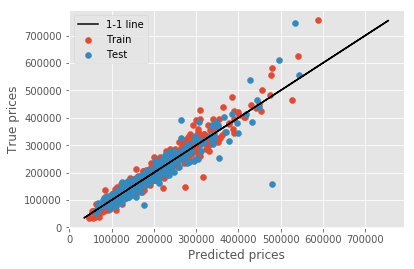

In [9]:
model_tmp = Ridge(alpha=alpha)
model_tmp = model_tmp.fit(X_train,y_train)

print('Model train accuracy (rmsle): ', rmsle(model_tmp, X_train, y_train))
print('Model test accuracy (rmsle): ', rmsle(model_tmp, X_test, y_test))

plt.scatter(np.exp(model_tmp.predict(X_train)), np.exp(y_train), label='Train')
plt.scatter(np.exp(model_tmp.predict(X_test)), np.exp(y_test), label='Test')
plt.plot(np.exp(y), np.exp(y), c='black', label = '1-1 line')
plt.xlabel('Predicted prices')
plt.ylabel('True prices')
_ = plt.legend()


We train the model on the whole dataset

In [10]:
model1a = Ridge(alpha=alpha)
model1a.fit(X,y)

score1a = rmsle(model1a, X, y)

print('Model accuracy rmsle: ', rmsle(model1a, X, y))

Model accuracy rmsle:  0.10087939159840298


We plot regression coefficients

<BarContainer object of 20 artists>

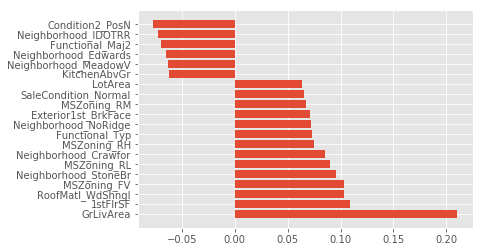

In [11]:
coefs = pd.DataFrame({'Feature':X.columns.values, 'Coefficient':model1a.coef_})

# Plot the most important features
coefs['sort'] = coefs.Coefficient.abs()
coefs = coefs.sort_values('sort', ascending=False).drop('sort', axis=1).head(20).sort_values('Coefficient', ascending=False)
plt.barh(coefs.Feature, coefs.Coefficient)

### Model 1b: LASSO regularization 

Alpha : 0.00015000000000000001
Model accuracy train : 0.12063486912320372
Model accuracy test: 0.1427241910909587


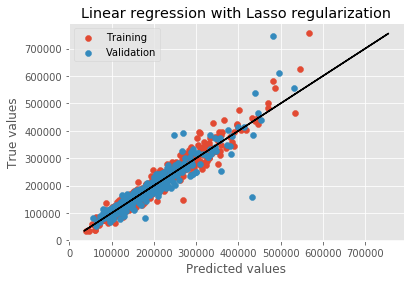

In [12]:
alphas = np.linspace(0.0001,1,20)

lasso = LassoCV(alphas = alphas, 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_


# Narrow down alpha
alphas = alpha * np.linspace(0.5, 1.5, 10)

lasso = LassoCV(alphas = alphas, 
                max_iter = 50000, cv = 10)

# Fit the model
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Alpha :", alpha)

print("Model accuracy train :", rmse_cv(lasso, X_train, y_train).mean())
print("Model accuracy test:", rmse_cv(lasso, X_test, y_test).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)


# Plot predictions
plt.scatter(np.exp(y_train_las), np.exp(y_train), label = "Training")
plt.scatter(np.exp(y_test_las), np.exp(y_test), label = "Validation")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.legend()
plt.plot(np.exp(y), np.exp(y), c = "black")


In [13]:
model1b = Lasso(alpha=alpha)
model1b.fit(X,y)

score1b =  rmsle(model1b, X, y)

print('Model accuracy rmsle: ', rmsle(model1b, X, y))

Model accuracy rmsle:  0.09829381076458753


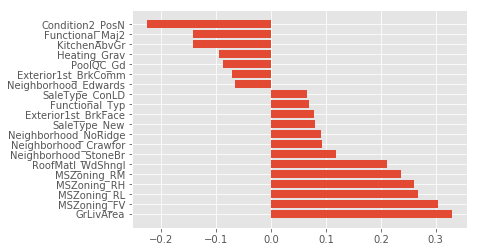

In [14]:
# Plot important coefficients
coefs = pd.DataFrame({'Feature':X.columns.values, 'Coefficient':model1b.coef_})

# Plot the most important features
coefs['sort'] = coefs.Coefficient.abs()
coefs = coefs.sort_values('sort', ascending=False).drop('sort', axis=1).head(20).sort_values('Coefficient', ascending=False)
plt.barh(coefs.Feature, coefs.Coefficient)
plt.savefig('./output/figX.png', dpi=300)
plt.show()


Train model on the whole dataset.

## Fitting the model on the selected features

The features that were selected in [Trees.ipynb](Trees.ipynb) are used to create regression models

In [15]:
# Load list of variables
select_var = pickle.load(open('./tmp/feaure_list_dt.list', 'rb'))

# Set new X
X_sel = X[select_var].copy()

### Model 2a: Ridge regularization

In [16]:
# Divide the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1022, 137)
X_test : (438, 137)
y_train : (1022,)
y_test : (438,)


Lowest rmse:  0.12413879557365312
Optimal alpha:  [5.43442211]


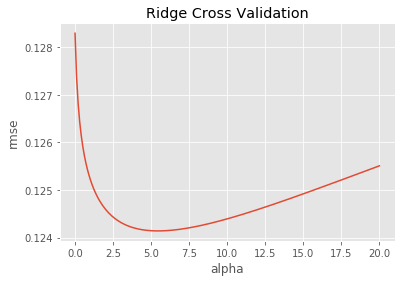

In [17]:

alphas = np.linspace(0.01,20,200)
cv_ridge = [rmse_cv(Ridge(alpha = alpha), X_train,y_train).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Ridge Cross Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")


print('Lowest rmse: ',cv_ridge.min())
print('Optimal alpha: ', cv_ridge[cv_ridge==cv_ridge.min()].index.values)

alpha = cv_ridge[cv_ridge==cv_ridge.min()].index.values

Fit model to the new train dataset and compare with new test.

Model train accuracy (rmsle):  0.10828470835746633
Model test accuracy (rmsle):  0.12374004493934436


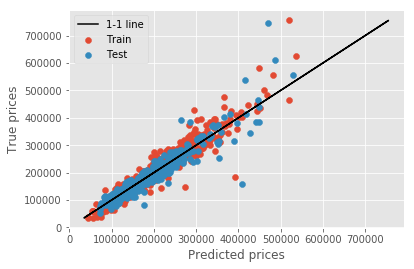

In [18]:
model_tmp = Ridge(alpha=alpha)
model_tmp = model_tmp.fit(X_train,y_train)

print('Model train accuracy (rmsle): ', rmsle(model_tmp, X_train, y_train))
print('Model test accuracy (rmsle): ', rmsle(model_tmp, X_test,y_test))

plt.scatter(np.exp(model_tmp.predict(X_train)), np.exp(y_train), label='Train')
plt.scatter(np.exp(model_tmp.predict(X_test)), np.exp(y_test), label='Test')
plt.plot(np.exp(y), np.exp(y), c='black', label = '1-1 line')
plt.xlabel('Predicted prices')
plt.ylabel('True prices')
_ = plt.legend()


We train the model on the whole dataset

In [19]:
model2a = Ridge(alpha=alpha)
model2a.fit(X_sel,y)

score2a = rmsle(model2a, X_sel, y)

print('Model accuracy (rmsle): ', rmsle(model2a, X_sel, y))

Model accuracy (rmsle):  0.1104011315476945


We plot regression coefficients

<BarContainer object of 20 artists>

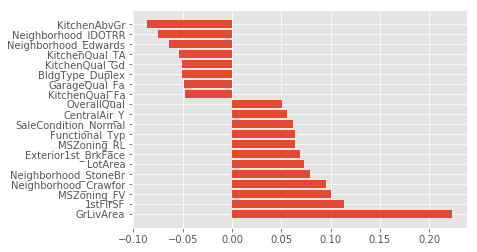

In [20]:
coefs = pd.DataFrame({'Feature':X_sel.columns.values, 'Coefficient':model2a.coef_})

# Plot the most important features
coefs['sort'] = coefs.Coefficient.abs()
coefs = coefs.sort_values('sort', ascending=False).drop('sort', axis=1).head(20).sort_values('Coefficient', ascending=False)
plt.barh(coefs.Feature, coefs.Coefficient)

## Model 2b: LASSO regularization 

Alpha : 0.00015000000000000001
Model accuracy (rmse) train : 0.12520088839931282
Model accuracy (rmse) test: 0.13855327463965533


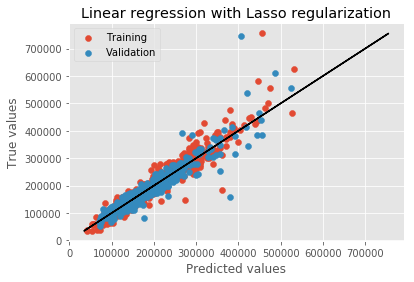

In [21]:
alphas = np.linspace(0.0001,1,20)

lasso = LassoCV(alphas = alphas, 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_


# Narrow down alpha
alphas = alpha * np.linspace(0.5, 1.5, 10)

lasso = LassoCV(alphas = alphas, 
                max_iter = 50000, cv = 10)

# Fit the model
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Alpha :", alpha)

print("Model accuracy (rmse) train :", rmse_cv(lasso, X_train, y_train).mean())
print("Model accuracy (rmse) test:", rmse_cv(lasso, X_test, y_test).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)


# Plot predictions
plt.scatter(np.exp(y_train_las), np.exp(y_train), label = "Training")
plt.scatter(np.exp(y_test_las), np.exp(y_test), label = "Validation")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.legend()
plt.plot(np.exp(y), np.exp(y), c = "black")
plt.savefig('./output/figX.png', dpi=300)
plt.show()




In [22]:
model2b = Lasso(alpha=alpha)
model2b.fit(X_sel,y)

score2b = rmsle(model2b, X_sel, y)

print('Model accuracy (rmsle): ', rmsle(model2b, X_sel, y))

Model accuracy (rmsle):  0.11000660302675072


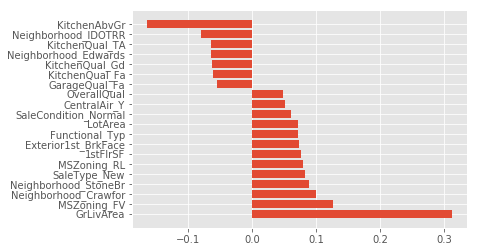

In [23]:
# Plot important coefficients
coefs = pd.DataFrame({'Feature':X_sel.columns.values, 'Coefficient':model2b.coef_})

# Plot the most important features
coefs['sort'] = coefs.Coefficient.abs()
coefs = coefs.sort_values('sort', ascending=False).drop('sort', axis=1).head(20).sort_values('Coefficient', ascending=False)
plt.barh(coefs.Feature, coefs.Coefficient)
plt.savefig('./output/figX.png', dpi=300)
plt.show()


## Combine the models

We combine the models and pickle them for use on the train set

In [25]:
# Models

models = ['model1a', 'model1b', 'model2a', 'model2b']
scores = [score1a, score1b, score2a, score2b]

models_comb = pd.DataFrame({'model':models, 'score': scores})
print(models_comb)

# Pickle
pickle.dump(models_comb, open('./tmp/models_comb', 'wb'))

     model     score
0  model1a  0.100879
1  model1b  0.098294
2  model2a  0.110401
3  model2b  0.110007


Pickle models

In [26]:
models_obj = [model1a, model1b, model2a, model2b]

for i, model in enumerate(models_obj):
    name = './tmp/'+models[i]+'.model'
    pickle.dump(model, open(name, 'wb'))
